In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Matplotlib customizations.
plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("legend", edgecolor='none')

# ROM Operator Inference Tutorial

The `rom_operator_inference` package constructs reduced-order models (ROM) for large dynamical systems.
Such systems often arise from the numerical solution of partial differentials equations (PDE).
In this tutorial, we give an example of solving a **very** simple heat equation with a ROM learned from data via Operator Inference.

## Problem Statement and Numerical Setting

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $\omega$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$.
We consider the one-dimensional heat equation with homogeneous Dirichlet boundary conditions,
$$
\begin{align*}
    \frac{\partial}{\partial t} x(\omega,t) - \frac{\partial^2}{\partial\omega^2}x(\omega,t) &= 0
    & \omega &\in\Omega,\quad t\in(0,T],
    \\
    x(0,t) = x(L,t) &= 0
    & t &\in[0,T],
    \\
    x(\omega,0) &= \omega(1 - \omega),
    & \omega &\in \Omega.
\end{align*}
$$

This is a model for a one-dimensional rod that conducts heat: the temperature at the ends of the rod are fixed at $0$ and heat is allowed to flow out of the rod through the ends.

To solve the problem numerically, let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$

Since the boundary conditions prescribe $x(\omega_0,t) = x(\omega_{n+1},t) = 0$, we wish to compute the state vector

$$
\mathbf{x}(t) = \left[\begin{array}{c} x(\omega_1,t) \\ \vdots \\ x(\omega_n,t)\end{array}\right]\in\mathbb{R}^n
$$

for various $t\in[0,T]$.

Introducing the central finite difference approximation

$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$

we obtain the semi-discrete linear system

$$
\boxed{
\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t),
\qquad
\mathbf{x}(0) = \mathbf{x}_0
}\,,
$$

where

$$
\begin{align*}
    A &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{x}_0 &= \left[\begin{array}{c}
    \omega_1 (1 - \omega_1) \\ \omega_2 (1 - \omega_2) \\ \vdots \\ \omega_{n-1} (1 - \omega_{n-1}) \\ \omega_n (1 - \omega_n)
    \end{array}\right] \in\mathbb{R}^{n}.
\end{align*}
$$

The boxed equation is the _full-order model_ (FOM).
Our goal is to construct a reduced-order model (ROM) that approximates the FOM.

### Snapshot Data Generation

For simplicity, let $L = T = 1$.
We begin by simulating the full-order system described above with a maximal time step size $\delta t = 10^{-3}$, resulting in $k = 10^3+1$ time steps (1000 steps after the initial condition).
The results are organized as the _snapshot matrix_ $X\in\mathbb{R}^{n\times k}$, where the $j$th column is the solution trajectory at time $t_j$.

In [3]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
w_all = np.linspace(0, L, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid (where x is unknown).
dw = w[1] - w[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*1000+1                    # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0078125
Temporal step size dt = 0.001


In [4]:
# Construct the state matrix A.
diags = np.array([1,-2,1]) / (dw**2)
A = sparse.diags(diags, [-1,0,1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
f = lambda t,x: A @ x
x0 = w * (1 - w)

print(f"shape of A:\t{A.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A:	(127, 127)
shape of x0:	(127,)


In [5]:
# Compute snapshots by solving the full-order model with SciPy.
X = solve_ivp(f, [0,T], x0, t_eval=t, method="BDF", max_step=dt).y

print(f"shape of X:\t{X.shape}")

shape of X:	(127, 1001)


Finally, we visualize the snapshots to get a sense of how the solution looks qualitatively.

In [6]:
def plot_heat_data(Z, title):
    fig, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 20, 80, 160, 320, 640]
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(w_all, x_all, color=next(color), label=rf"$x(\omega,t_{{{j}}})$")

    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$x(\omega,t)$")
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.suptitle(title)

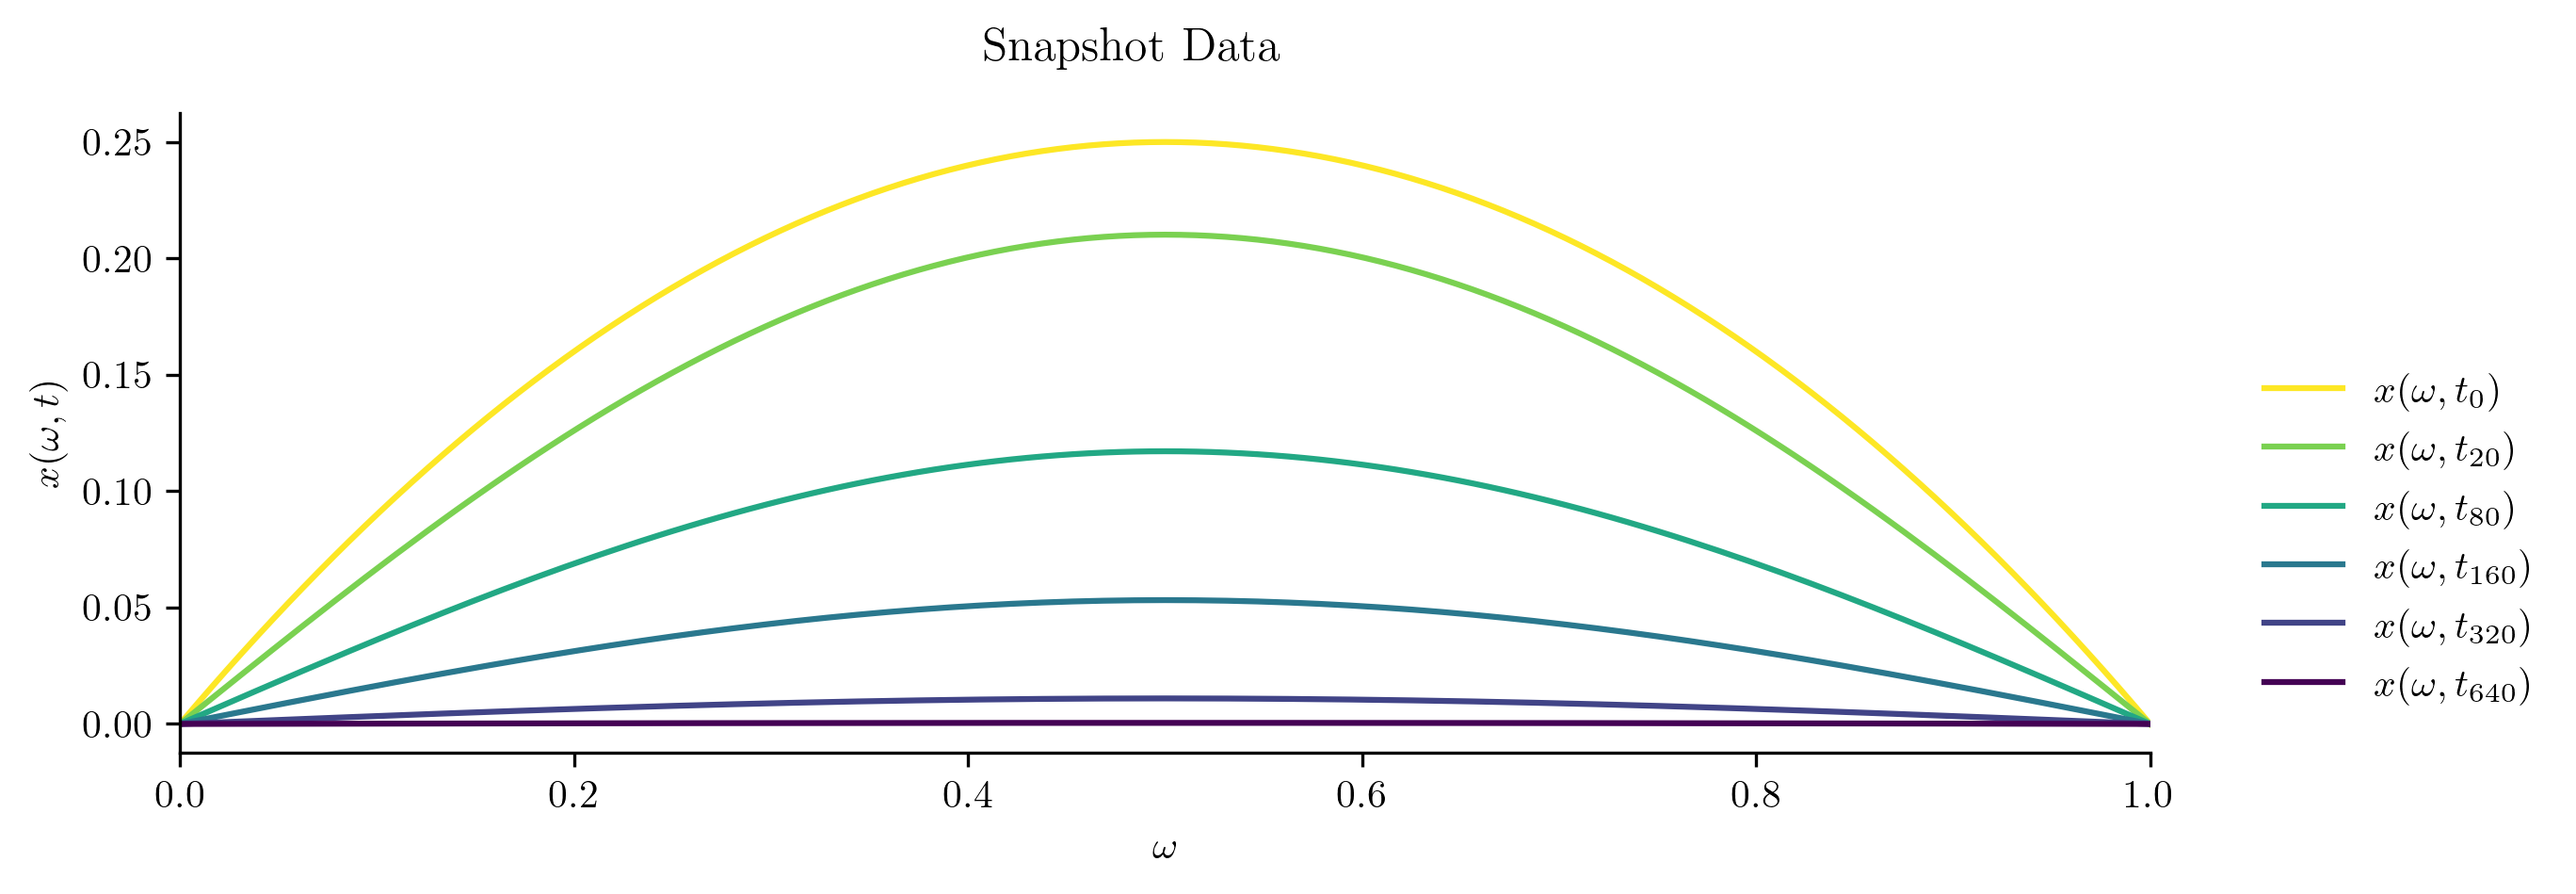

In [7]:
plot_heat_data(X, "Snapshot Data")

Initially there is more heat toward the center of the rod, which then diffuses out of the ends of the rod.

### Summary

At this point, we have gathered some training data by simulating the FOM.
We also have an initial condition and space and time domains.

| Name | Symbol | Code Variable |
| :--- | :----: | :------------ |
| State snapshots | $X$ | `X` |
| Initial state | $\mathbf{x}_0$ | `x0` |
| | |
| Spatial variable | $\Omega$ | `w` |
| Time domain | $[0,T]$ | `t` |

## Using the Package

Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$
but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$.

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

In [8]:
import rom_operator_inference as roi

Vr, _ = roi.pre.pod_basis(X, r=2)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X, dt, order=6)                     # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")        # Define the model structure.
model.fit(Vr, X, Xdot)                                  # Construct the ROM with Operator Inference.
X_ROM = model.predict(x0, t, method="BDF", max_step=dt) # Simulate the ROM.
roi.post.frobenius_error(X, X_ROM)[1]                   # Calculate the relative error of the ROM simulation.

0.0008718326834296938

### Choosing the Reduced-model Dimension

There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [9]:
svdvals = la.svdvals(X)

In [10]:
import rom_operator_inference as roi

roi.pre.svdval_decay?

Signature: roi.pre.svdval_decay(singular_values, eps, plot=False)
Docstring:
Count the number of singular values of X that are greater than eps.

Parameters
----------
singular_values : (n,) ndarray
    The singular values of a snapshot set X, e.g., scipy.linalg.svdvals(X).

eps : float or list(float)
    Cutoff value(s) for the singular values of X.

plot : bool
    If True, plot the singular values and the cutoff value(s) against the
    singular value index.

Returns
-------
ranks : int or list(int)
    The number of singular values greater than the cutoff value(s).
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/pre/_basis.py
Type:      function


5

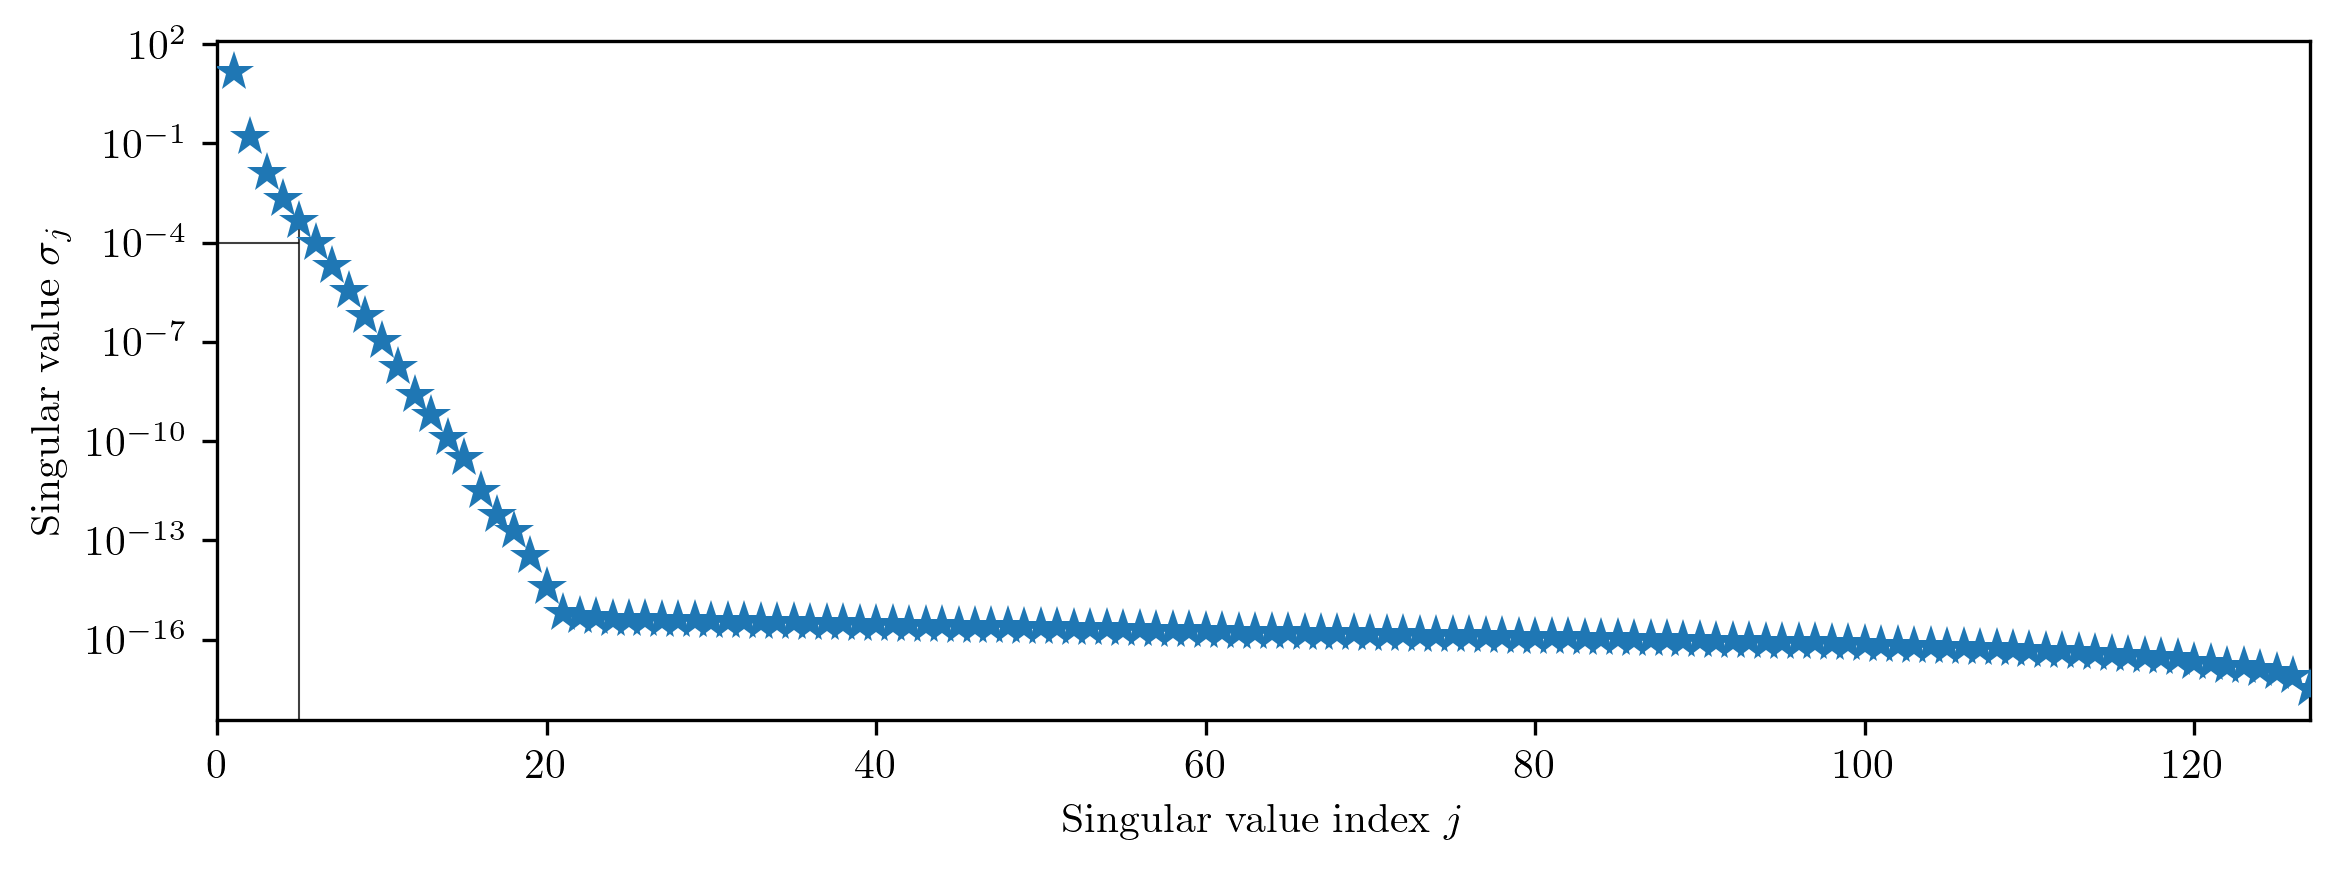

In [11]:
roi.pre.svdval_decay(svdvals, 1e-4, plot=True)

We can also look at the relative contribution of the singular values, i.e., choose $r$ such that
$$
    \kappa_r = \frac{\sum_{j=1}^r \sigma_j^2}{\sum_{j=1}^n \sigma_j^2}
$$
is greater than a given value (usually something very close to $1$).

In [12]:
roi.pre.cumulative_energy?

Signature: roi.pre.cumulative_energy(singular_values, thresh, plot=False)
Docstring:
Compute the number of singular values of X needed to surpass a given
energy threshold. The energy of j singular values is defined by

    energy_j = sum(singular_values[:j]**2) / sum(singular_values**2).

Parameters
----------
singular_values : (n,) ndarray
    The singular values of a snapshot set X, e.g., scipy.linalg.svdvals(X).

thresh : float or list(float)
    Energy capture threshold(s).

plot : bool
    If True, plot the singular values and the cumulative energy against
    the singular value index (linear scale).

Returns
-------
ranks : int or list(int)
    The number of singular values required to capture more than each
    energy capture threshold.
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/pre/_basis.py
Type:      function


In [13]:
r = roi.pre.cumulative_energy(svdvals, .999999, plot=False)
print(f"r = {r}")

r = 2


This indicates that we can capture 99.9999% of the behavior of the FOM with only 2 modes.
This is a very small choice of $r$, but it is also a very simple problem, so for now we select $r = 2$.

### Constructing a Low-dimensional Subspace

Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [14]:
roi.pre.pod_basis?

Signature: roi.pre.pod_basis(X, r=None, mode='dense', **options)
Docstring:
Compute the POD basis of rank r corresponding to the data in X.
This function does NOT shift or scale data before computing the basis.
This function is a simple wrapper for various SVD methods.

Parameters
----------
X : (n,k) ndarray
    A matrix of k snapshots. Each column is a single snapshot.

r : int
    The number of POD basis vectors and singular values to compute.
    If None (default), compute the full SVD.

mode : str
    The strategy to use for computing the truncated SVD of X. Options:
    * "dense" (default): Use scipy.linalg.svd() to compute the SVD of X.
        May be inefficient or intractable for very large matrices.
    * "sparse": Use scipy.sparse.linalg.svds() to compute the SVD of X.
        This uses ARPACK for the eigensolver. Inefficient for non-sparse
        matrices; requires separate computations for full SVD.
    * "randomized": Compute an approximate SVD with a randomized approach

In [15]:
r = 2
Vr, _ = roi.pre.pod_basis(X, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (127, 2)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

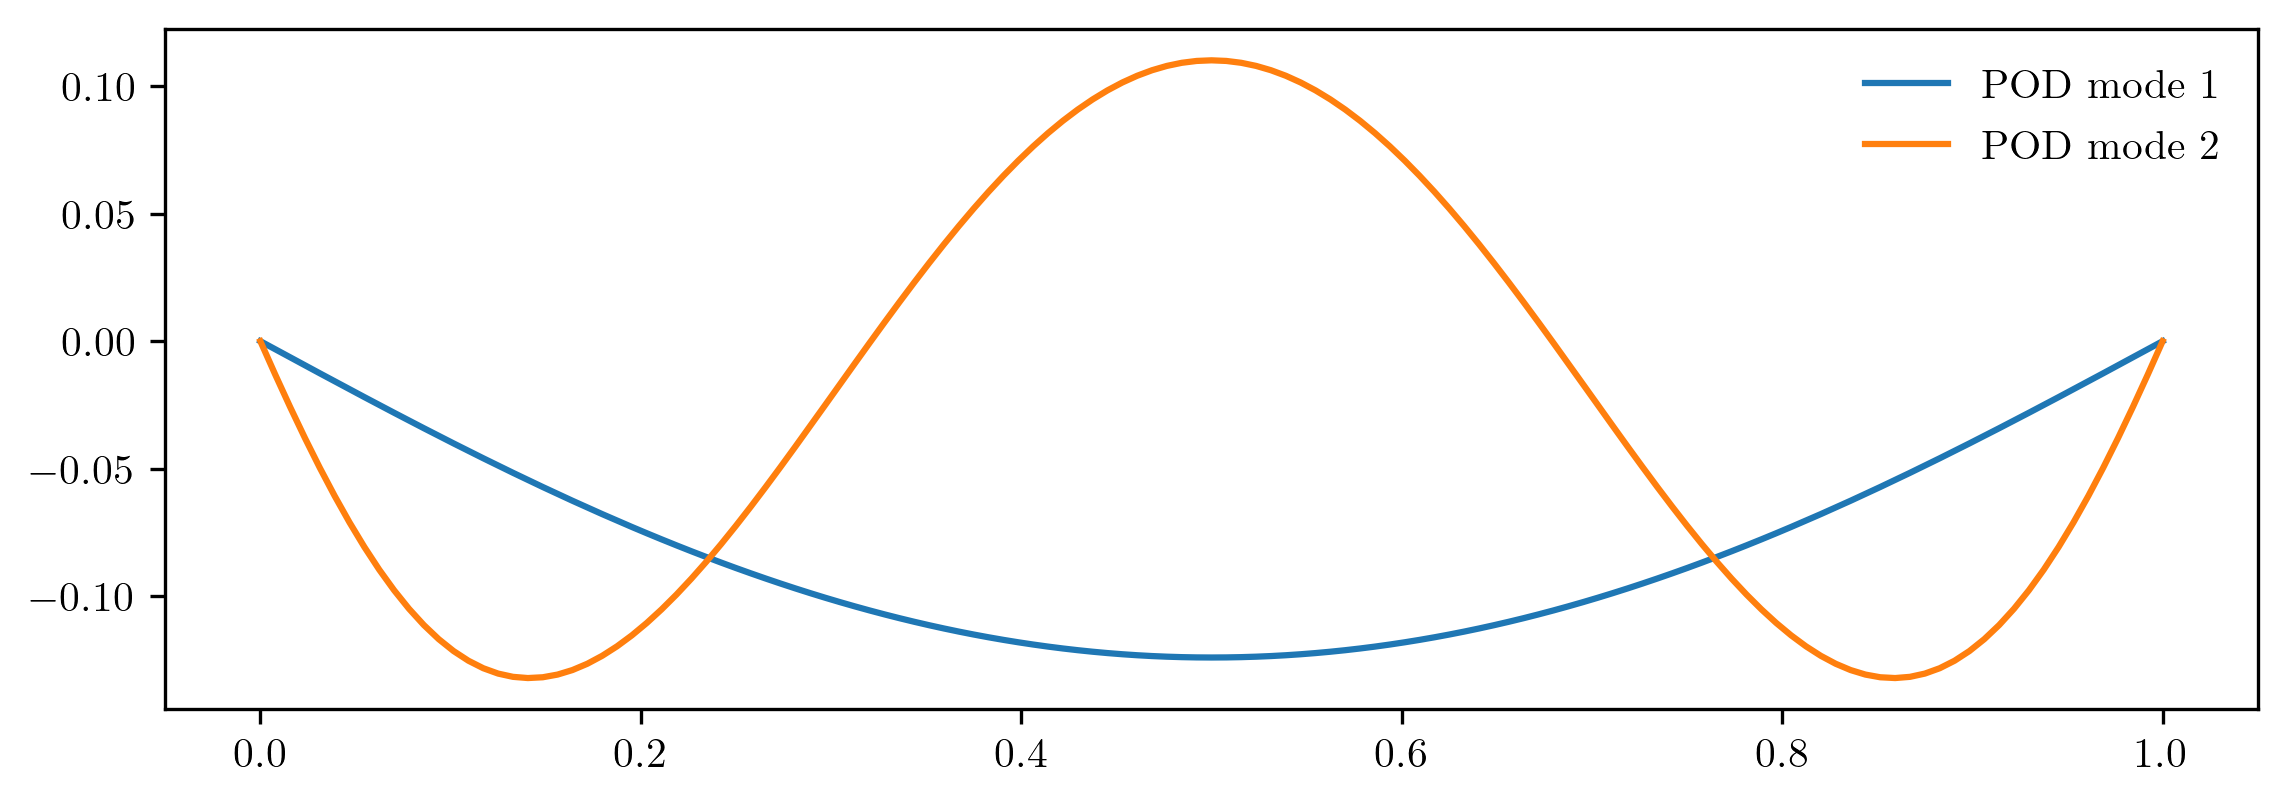

In [16]:
for j in range(Vr.shape[1]):
    plt.plot(w_all, np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()

Finally, the basis $V_r$ induces a lower bound for the error that we expect from any ROM that uses that basis, called the _projection error_.

In [17]:
roi.pre.projection_error?

Signature: roi.pre.projection_error(X, Vr)
Docstring:
Calculate the projection error induced by the reduced basis Vr, given by

    err = ||X - Vr Vr^T X|| / ||X||,

since (Vr Vr^T) is the orthogonal projector onto the range of Vr.

Parameters
----------
X : (n,k) or (k,) ndarray
    A 2D matrix of k snapshots where each column is a single snapshot, or a
    single 1D snapshot. If 2D, use the Frobenius norm; if 1D, the l2 norm.

Vr : (n,r) ndarray
    The reduced basis of rank r. Each column is one basis vector.

Returns
-------
error : float
    The projection error.
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/pre/_basis.py
Type:      function


In [18]:
roi.pre.projection_error(X, Vr)

0.0008634530661542434

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

In [19]:
Xdot = A @ X

print(f"Shape of X:\t{X.shape}")
print(f"Shape of Xdot:\t{Xdot.shape}")

Shape of X:	(127, 1001)
Shape of Xdot:	(127, 1001)


If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

In [20]:
roi.pre.xdot_uniform?

Signature: roi.pre.xdot_uniform(X, dt, order=2)
Docstring:
Approximate the time derivatives for a chunk of snapshots that are
uniformly spaced in time.

Parameters
----------
X : (n,k) ndarray
    The data to estimate the derivative of. The jth column is a snapshot
    that corresponds to the jth time step, i.e., X[:,j] = x(t[j]).

dt : float
    The time step between the snapshots, i.e., t[j+1] - t[j] = dt.

order : int {2, 4, 6}
    The order of the derivative approximation.
    See https://en.wikipedia.org/wiki/Finite_difference_coefficient.

Returns
-------
Xdot : (n,k) ndarray
    Approximate time derivative of the snapshot data. The jth column is
    the derivative dx / dt corresponding to the jth snapshot, X[:,j].
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/pre/_finite_difference.py
Type:      function


In [21]:
Xdot2 = roi.pre.xdot_uniform(X, dt, order=6)

# Check that the estimate is close to the true time derivatives.
la.norm(Xdot - Xdot2, ord=np.inf) / la.norm(Xdot, ord=np.inf)

0.004826536027917912

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [22]:
X_ = Vr.T @ X                                   # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, dt, order = 6) # Estimate the projected time derivatives.

np.allclose(Vr.T @ Xdot2, Xdot_)                # Same as project the full-order time derivatives.

True

### Constructing the ROM via Operator Inference

We now have training data and a linear basis for a low-dimensional subspace.

| Name | Symbol | Code Variable |
| :--- | :----: | :------------ |
| State snapshots | $X$ | `X` |
| Time derivatives | $\dot{X}$ | `Xdot` |
| POD basis | $V_{r}$ | `Vr` |
| Initial state | $\mathbf{x}_0$ | `x0` |
| | |
| Spatial domain | $\Omega$ | `w` |
| Time domain | $[0,T]$ | `t` |

Next, we initialize a `rom_operator_inference` "ROM" class and fit it to the data.
Since the problem is continuous (time-dependent) and there are no external parameters, we use the `InferredContinuousROM` class.
The constructor takes a single parameter, `modelform`, that specifies the structure of the desired model.

| Character | Name | Reduced-order Model Term |
| :-------- | :--- | :------- |
| `c` | Constant |  $\hat{\mathbf{c}}$ |
| `A` | Linear |  $\hat{A}\hat{\mathbf{x}}(t)$ |
| `H` | Quadratic |  $\hat{H}\left(\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\right)(t)$ |
| `G` | Cubic |  $\hat{G}\left(\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\right)(t)$ |
| `B` | Input |  $\hat{B}\mathbf{u}(t)$ |

Since we seek a ROM of the form $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t)$, we set `modelform="A"`.
If there were a constant term, $\frac{d}{dt}\hat{\mathbf{x}}(t) = \mathbf{c} + \hat{A}\hat{\mathbf{x}}(t)$, we would use `modelform="cA"`, and so on.
Beware that with cubic terms ($G$), the data matrix starts to get very large.

In [23]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [24]:
model.fit?

Signature: model.fit(Vr, X, Xdot, U=None, P=0, **kwargs)
Docstring:
Solve for the reduced model operators via ordinary least squares.

Parameters
----------
Vr : (n,r) ndarray or None
    The basis for the linear reduced space (e.g., POD basis matrix).
    If None, X and Xdot are assumed to already be projected (r,k).

X : (n,k) or (r,k) ndarray
    Column-wise snapshot training data (each column is a snapshot),
    either full order (n rows) or projected to reduced order (r rows).

Xdot : (n,k) or (r,k) ndarray
    Column-wise time derivative training data (each column is a
    snapshot), either full order (n rows) or projected to reduced
    order (r rows).

U : (m,k) or (k,) ndarray or None
    Column-wise inputs corresponding to the snapshots. If m=1 (scalar
    input), then U may be a one-dimensional array. Required if 'B' is
    in `modelform`; must be None if 'B' is not in `modelform`.

P : float >= 0 or (d,d) ndarray or list of r (floats or (d,d) ndarrays)
    Tikhonov regulari

In [25]:
model.fit(Vr, X, Xdot)

After fitting the model, we can directly examine the inferred operators of the model.

In [26]:
model.A_

array([[ -9.87392047,  -0.62781559],
       [ -0.62781559, -92.6077519 ]])

Because this is such a simple problem, Operator Inference recovers the exact same operator $\hat{A}$ as intrusive projection, i.e., $\tilde{A} = V_r^\mathsf{T} A V_r$:

In [27]:
Atilde = Vr.T @ A @ Vr
Atilde

array([[ -9.87392047,  -0.62781559],
       [ -0.62781559, -92.6077519 ]])

In [28]:
np.allclose(model.A_, Atilde)

True

### Simulating the Reduced Model

Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [29]:
model.predict?

Signature: model.predict(x0, t, u=None, **options)
Docstring:
Simulate the learned ROM with scipy.integrate.solve_ivp().

Parameters
----------
x0 : (n,) or (r,) ndarray
    The initial state vector, either full order (n-vector) or projected
    to reduced order (r-vector).

t : (nt,) ndarray
    The time domain over which to integrate the reduced-order system.

u : callable or (m,nt) ndarray
    The input as a function of time (preferred) or the input at the
    times `t`. If given as an array, u(t) is approximated by a cubic
    spline interpolating the known data points.

options
    Arguments for solver.integrate.solve_ivp(), such as the following:
    method : str
        The ODE solver for the reduced-order system.
        * 'RK45' (default): Explicit Runge-Kutta method of order 5(4).
        * 'RK23': Explicit Runge-Kutta method of order 3(2).
        * 'Radau': Implicit Runge-Kutta method of the Radau IIA family
            of order 5.
        * 'BDF': Implicit multi-step varia

In [30]:
X_ROM = model.predict(x0, t, method="BDF", max_step=dt)
X_ROM.shape

(127, 1001)

The `predict()` method is convenient, but `scipy.integrate.solve_ivp()` implements relatively few solver schemes.  However, the ROM can be simulated by **any** ODE solver scheme by extracting the inferred operator $\hat{A}$. 
If `solver(A, x0)` were a solver for systems of the form $\frac{d}{dt}\mathbf{x} = A\mathbf{x}(t),\ \mathbf{x}(0)=\mathbf{x}_0$, we could simulate the ROM with the following code.

```python
x0_ = Vr.T @ x0              # Project the initial conditions.
X_ = solver(model.A_, x0_)   # Solve the ROM in the reduced space.
X_ROM = Vr @ X_              # Map the results to the full space.
```

More generally, the ROM object has a method `f_()` that represents the right-hand side of the model, the $\hat{\mathbf{f}}$ of $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{\mathbf{f}}(t, \hat{\mathbf{x}}(t))$.
All-purpose integrators can therefore be applied to the function `model.f_()`.

In [31]:
model.f_?

Signature: model.f_(t, x_, u=None)
Docstring:
ROM function for continuous models.

Parameters
----------
t : float
    Time, a scalar.

x_ : (r,) ndarray
    Reduced state vector corresponding to time `t`.

u : func(float) -> (m,)
    Input function that maps time `t` to an input vector of length m.
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/_core/_base.py
Type:      method


### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

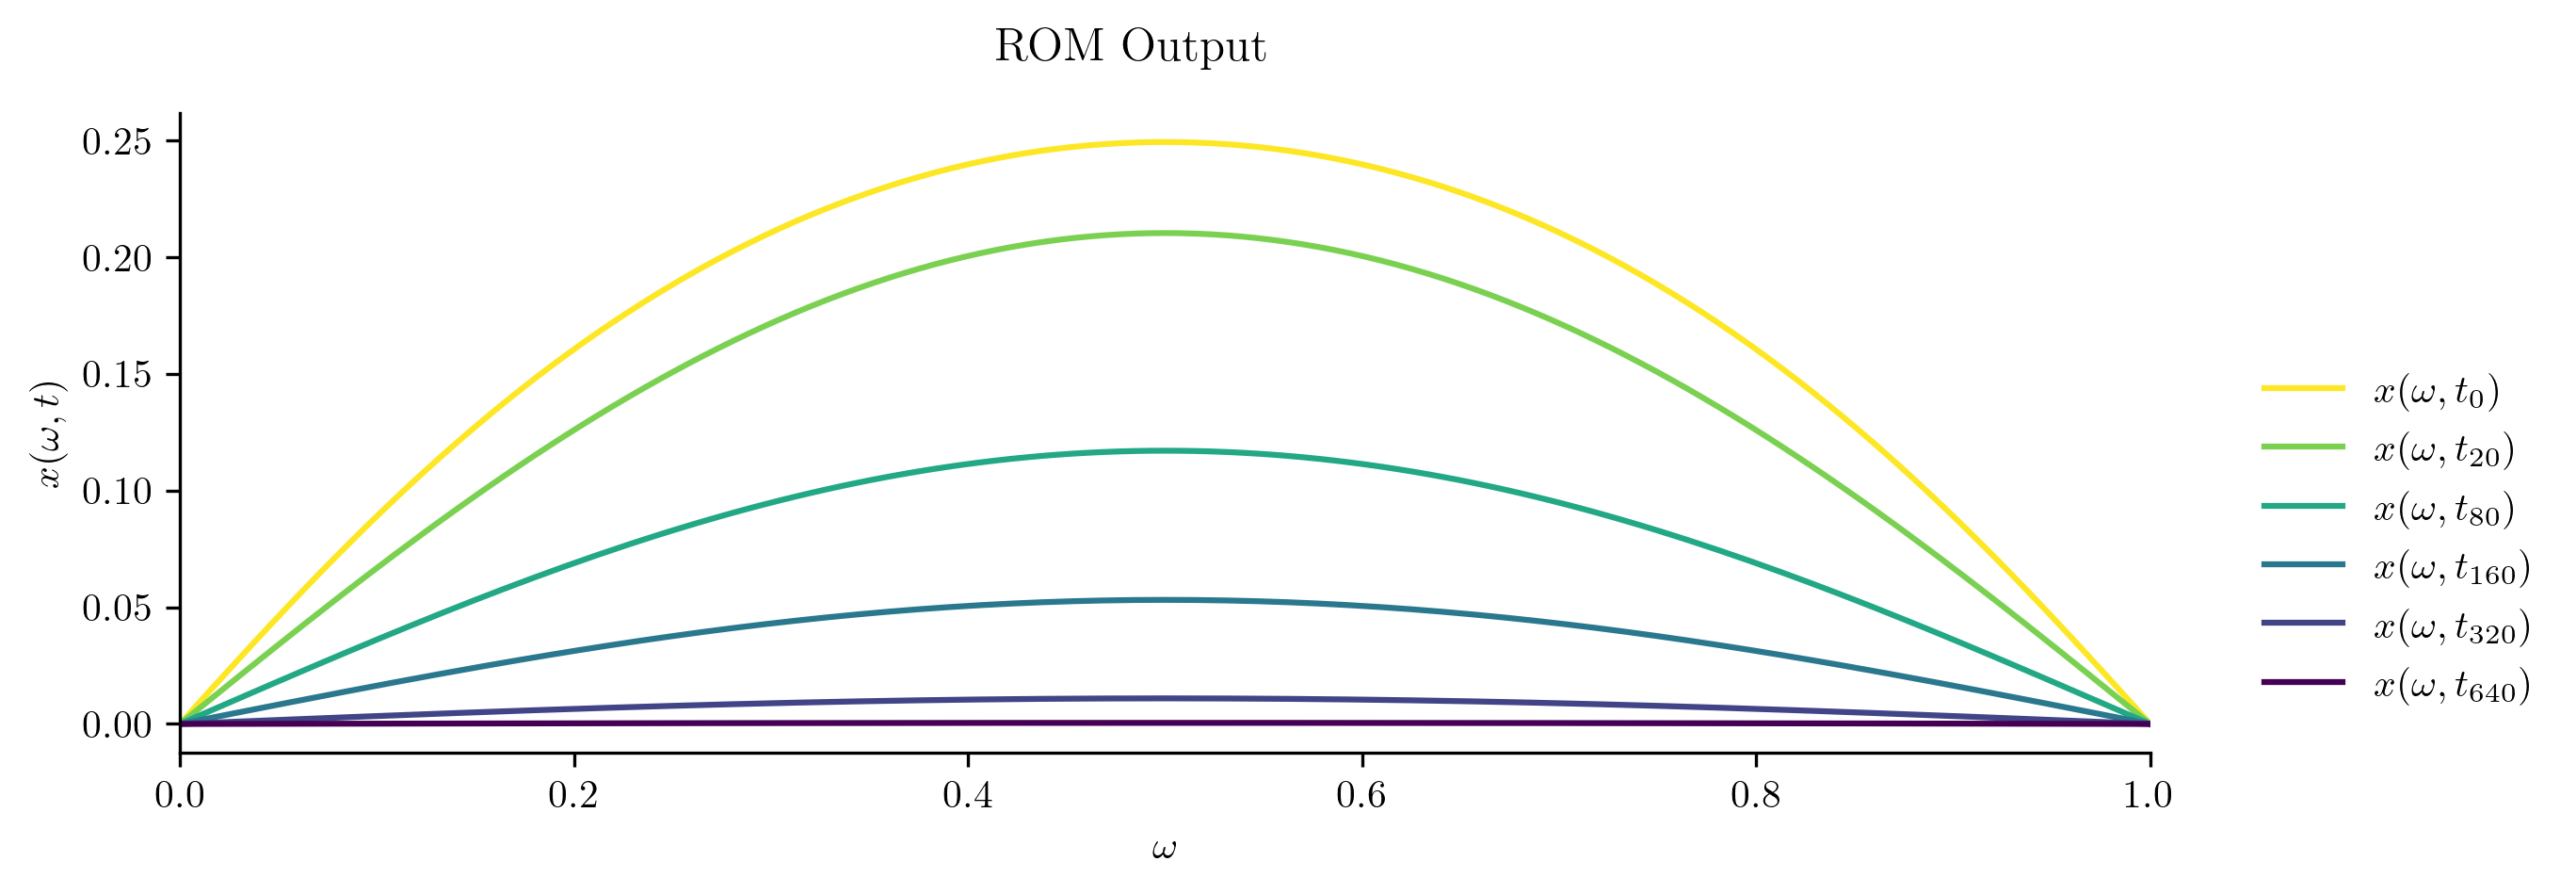

In [32]:
plot_heat_data(X_ROM, "ROM Output")

For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

In [33]:
roi.post.lp_error?

Signature: roi.post.lp_error(X, Y, p=2, normalize=False)
Docstring:
Compute the absolute and relative lp-norm errors between two snapshot
sets X and Y where Y is an approximation to X,

    Abs_Err_j = ||X_j - Y_j||_p,
    Rel_Err_j = ||X_j - Y_j||_p / ||X_j||_p = Abs_Err_j / ||X_j||_p.

Parameters
----------
X : (n,k) or (n,) ndarray
    The "true" data. Each column is one snapshot, i.e., X[:,j] is the data
    at some time t[j]. If one-dimensional, all of X is a single snapshot.

Y : (n,k) or (n,) ndarray
    An approximation to X, i.e., Y[:,j] approximates X[:,j] and corresponds
    to some time t[j]. If one-dimensional, all of Y is a single snapshot
    approximation.

p : float
    The order of the lp norm (default p=2 is the Euclidean norm). Used as
    the `ord` argument for scipy.linalg.norm(); see options at
    docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.norm.html.

normalize : bool
    If true, compute the normalized absolute error instead of the relative
    e

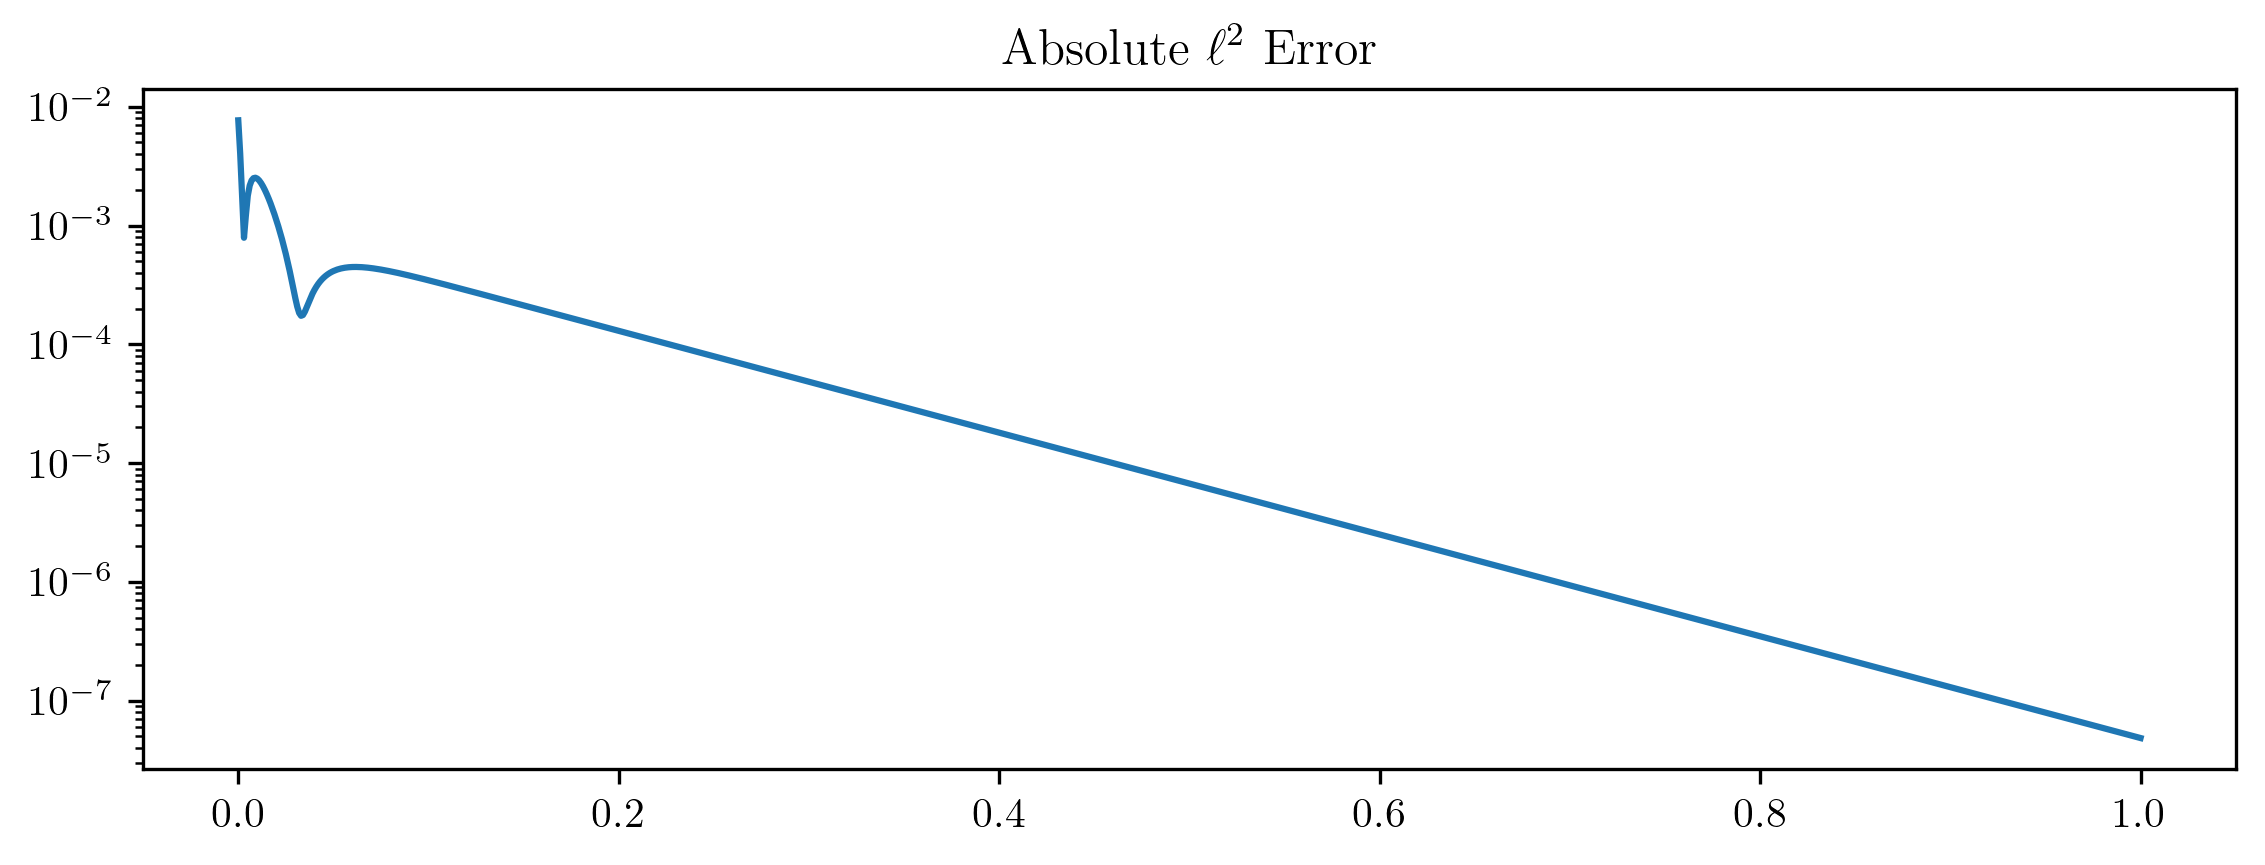

In [34]:
abs_l2err, rel_l2err = roi.post.lp_error(X, X_ROM)
plt.semilogy(t, abs_l2err)
plt.title(r"Absolute $\ell^2$ Error")
plt.show()

In this **extremely** simple example, the error decreases with time (as solutions get quickly pushed to zero), but this is not the kind of error behavior that should be expected for more complicated systems.

We can also get a scalar error measurement by calculating the relative Frobenius norm error.

In [35]:
roi.post.frobenius_error?

Signature: roi.post.frobenius_error(X, Y)
Docstring:
Compute the absolute and relative Frobenius-norm errors between two
snapshot sets X and Y where Y is an approximation to X,

    Abs_Err = ||X - Y||_F,
    Rel_Err = ||X - Y||_F / ||X||_F = Abs_Err / ||X||_F.

Parameters
----------
X : (n,k)
    The "true" data. Each column is one snapshot, i.e., X[:,j] is the data
    at some time t[j].

Y : (n,k)
    An approximation to X, i.e., Y[:,j] approximates X[:,j] and corresponds
    to some time t[j].

Returns
-------
abs_err : float
    The absolute error ||X - Y||_F.

rel_err : float
    The relative error ||X - Y||_F / ||X||_F.
File:      ~/opt/anaconda3/lib/python3.7/site-packages/rom_operator_inference/post/_errors.py
Type:      function


In [36]:
abs_froerr, rel_froerr = roi.post.frobenius_error(X, X_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 0.087242%


In other words, the ROM simulation is within 0.1% of the snapshot data.
Note that this value is very close to the projection error that we calculated earlier.